In [1]:
import os
import subprocess
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def set_mpi_params(use: bool, proc: int, mult: int, ngram = 3):
    with open('gradle.properties', 'w') as file:
        file.write('MPI_USE=%s\n' % ('true' if use else 'false'))
        file.write('MPI_PROC=%s\n' % proc)
        file.write('MPI_NGRAM=%d\n' % ngram)
        file.write('MPI_MULT=%d\n' % mult)

In [3]:
def freqs(output: str):
    freqs = {}
    for (word, freq) in re.findall(r'([а-я]+) -> (\d+.\d+)', out):
        freqs[word] = float(freq)
    return freqs

In [4]:
mults = [1,5,10]
procs = [1,2,4,6,8,10,12,14,16]
df = pd.DataFrame(columns=['proc', 'mult', 'ms'])
t_10_95 = 2.26215716274
for mult in mults:
    for proc in procs:
        set_mpi_params(use=proc > 1, proc=proc, mult=mult)
        mss = []
        for i in range(10):
            res = subprocess.run(['gradle', 'mpi'], capture_output=True)
            out = res.stdout.decode('utf8')
            ms = int(re.findall(r'in (\d+) ms', out)[-1])
            df.loc[len(df)] = [proc, mult, ms]
        local = df[(df.proc == proc) & (df.mult == mult)]
        mean = local.ms.mean()
        std = local.ms.std()
        delta = std * t_10_95
        print('mult=%d, proc=%d: %d ms ± %d ms = [%d, %d] ms' % (mult, proc, mean, delta, mean - delta, mean + delta))
df.ms = df.ms.astype(int)

mult=1, proc=1: 2168 ms ± 462 ms = [1705, 2631] ms
mult=1, proc=2: 1876 ms ± 311 ms = [1565, 2187] ms
mult=1, proc=4: 1713 ms ± 121 ms = [1591, 1834] ms
mult=1, proc=6: 2017 ms ± 90 ms = [1927, 2107] ms
mult=1, proc=8: 2446 ms ± 170 ms = [2275, 2616] ms
mult=1, proc=10: 2615 ms ± 138 ms = [2477, 2753] ms
mult=1, proc=12: 2905 ms ± 673 ms = [2231, 3579] ms
mult=1, proc=14: 4172 ms ± 2300 ms = [1872, 6473] ms
mult=1, proc=16: 3684 ms ± 750 ms = [2934, 4435] ms
mult=5, proc=1: 9098 ms ± 826 ms = [8271, 9925] ms
mult=5, proc=2: 5430 ms ± 369 ms = [5060, 5799] ms
mult=5, proc=4: 3721 ms ± 267 ms = [3453, 3988] ms
mult=5, proc=6: 3637 ms ± 340 ms = [3296, 3977] ms
mult=5, proc=8: 4242 ms ± 410 ms = [3832, 4653] ms
mult=5, proc=10: 5079 ms ± 937 ms = [4142, 6016] ms
mult=5, proc=12: 5630 ms ± 1137 ms = [4492, 6768] ms
mult=5, proc=14: 6926 ms ± 930 ms = [5995, 7856] ms
mult=5, proc=16: 7022 ms ± 1834 ms = [5187, 8856] ms
mult=10, proc=1: 19606 ms ± 8785 ms = [10820, 28392] ms
mult=10, proc=2:

In [5]:
df.to_csv('data.csv')

In [6]:
freqs(out)

{'что': 0.42,
 'его': 0.37,
 'ост': 0.33,
 'ого': 0.32,
 'про': 0.3,
 'ото': 0.27,
 'как': 0.26,
 'ени': 0.26,
 'ста': 0.26,
 'при': 0.25,
 'ово': 0.23,
 'ест': 0.23,
 'ать': 0.23,
 'это': 0.23,
 'аза': 0.23,
 'все': 0.22,
 'оро': 0.21,
 'сто': 0.21,
 'енн': 0.21,
 'был': 0.21}

In [7]:
groups = df.groupby(['mult', 'proc'])
mean = groups.mean()
std = groups.std()
delta = std * t_10_95
lower = mean - delta
upper = mean + delta
agg = pd.concat([mean, lower, upper], axis=1)
agg.columns = ['means', 'upper', 'lower']
agg = agg / 1000
agg

means      upper      lower
mult proc                               
1    1      2.1685   1.705548   2.631452
     2      1.8762   1.565050   2.187350
     4      1.7130   1.591142   1.834858
     6      2.0177   1.927459   2.107941
     8      2.4462   2.275812   2.616588
     10     2.6153   2.477203   2.753397
     12     2.9055   2.231930   3.579070
     14     4.1727   1.872299   6.473101
     16     3.6849   2.934318   4.435482
5    1      9.0985   8.271911   9.925089
     2      5.4302   5.060650   5.799750
     4      3.7211   3.453690   3.988510
     6      3.6371   3.296338   3.977862
     8      4.2428   3.832158   4.653442
     10     5.0796   4.142320   6.016880
     12     5.6306   4.492753   6.768447
     14     6.9261   5.995625   7.856575
     16     7.0221   5.187242   8.856958
10   1     19.6063  10.820310  28.392290
     2     10.2806   9.042236  11.518964
     4      6.9178   6.134525   7.701075
     6      6.3410   5.129527   7.552473
     8      6.6401   5.633910   7.646290
     10     7.1902   6.322635   8.057765
     12     7.9415   6.822208   9.060792
     14     9.2013   7.172549  11.230051
     16    10.3149   8.355849  12.273951

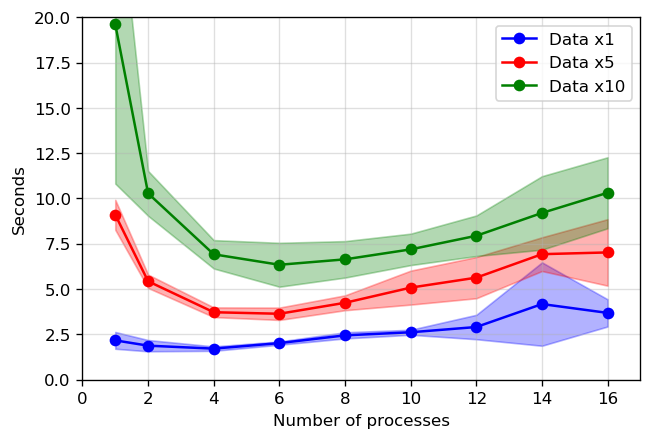

In [8]:
plt.figure(dpi=120)
plt.grid(alpha=0.4)
colors = {1: 'blue', 5: 'red', 10: 'green'}
for mult in mults:
    aggr = agg.loc[mult]
    plt.fill_between(aggr.index, aggr['lower'], aggr['upper'], color=colors[mult], alpha=0.3)
    plt.plot(aggr['means'], '-o', color=colors[mult])
plt.xlim(0, 17)
plt.xlabel('Number of processes')
plt.ylim(0, 20)
plt.ylabel('Seconds')
plt.legend(list(map(lambda x: "Data x" + str(x), mults)))
plt.show()

In [9]:
def draw_single(aggr, color):
    x_min = aggr.index.min() - 1
    x_max = aggr.index.max() + 1
    y_min = aggr['means'].min() - 1
    y_max = aggr['means'].max() + 1

    plt.figure(dpi=120)
    plt.grid(alpha=0.4)
    plt.fill_between(aggr.index, aggr['lower'], aggr['upper'], color=color, alpha=.3)
    plt.plot(aggr['means'], '-o', color=color)
    plt.xlim((x_min, x_max))
    plt.xlabel('Number of processes')
    plt.ylim((y_min, y_max))
    plt.ylabel('Seconds')
    plt.show()

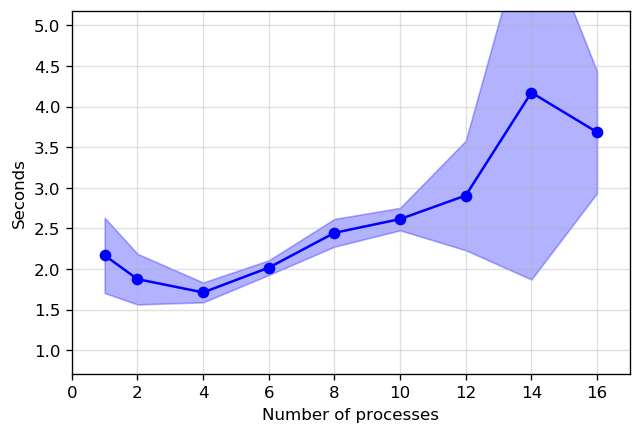

In [10]:
draw_single(agg.loc[1], colors[1])

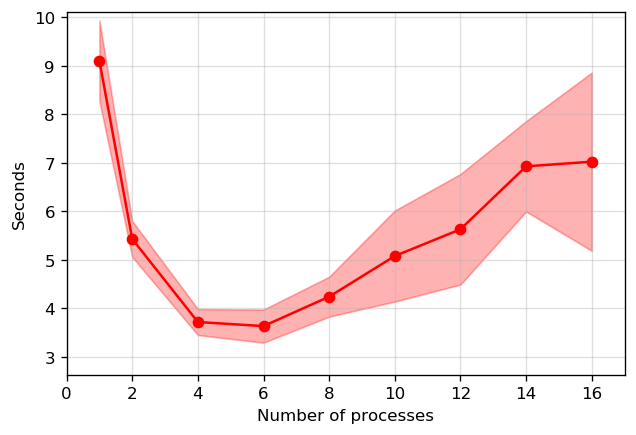

In [11]:
draw_single(agg.loc[5], colors[5])

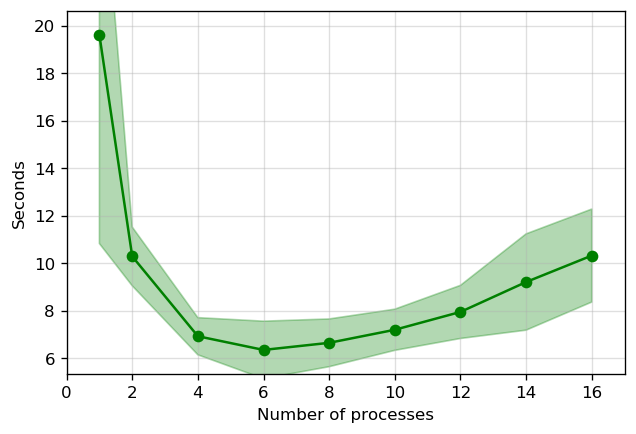

In [12]:
draw_single(agg.loc[10], colors[10])

In [13]:
spd = agg.drop(['upper', 'lower'], axis=1)
spd = spd.rename({'means': 'time'}, axis=1)
spd['mult'] = spd.index.droplevel(1)
spd['single_time'] = spd.apply(lambda x: spd.loc[x.mult, 1], axis=1).time
spd['speedup'] = spd.single_time / spd.time
speedup = spd['speedup']
pd.DataFrame(speedup)

speedup
mult proc          
1    1     1.000000
     2     1.155794
     4     1.265908
     6     1.074739
     8     0.886477
     10    0.829159
     12    0.746343
     14    0.519687
     16    0.588483
5    1     1.000000
     2     1.675537
     4     2.445110
     6     2.501581
     8     2.144456
     10    1.791184
     12    1.615902
     14    1.313654
     16    1.295695
10   1     1.000000
     2     1.907116
     4     2.834181
     6     3.091989
     8     2.952712
     10    2.726809
     12    2.468841
     14    2.130818
     16    1.900775

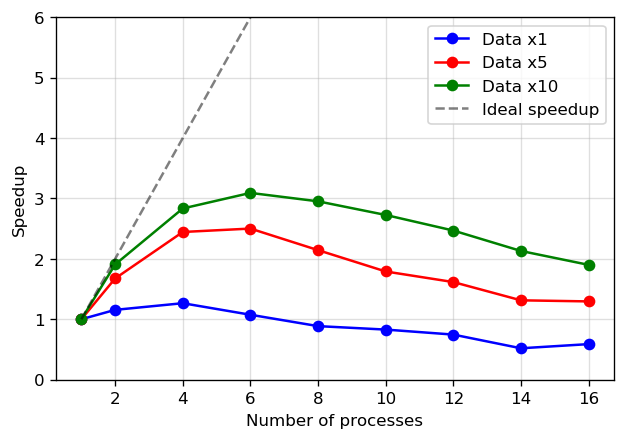

In [14]:
plt.figure(dpi=120)
plt.grid(alpha=0.4)
for mult in mults:
    plt.plot(speedup.loc[mult], '-o', color=colors[mult])
plt.plot(procs, procs, '--', color='k', alpha=0.5)
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.ylim(0, 6)
plt.legend(list(map(lambda x: "Data x" + str(x), mults)) + ['Ideal speedup'])
plt.show()